# autocorrelation
* Ref https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
* Ref http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [2]:
# Imports
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

/Users/danielcimring/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Get price data from Quandl
data = quandl.get("BCHAIN/MKPRU")
data = data.shift(-1) # data set has daily open, we want daily close
sp500 = pd.read_csv('^GSPC.csv', index_col = 0, parse_dates = [0])

In [4]:
# Lets ignore 2010
data = data.loc['2011-01-01':]

In [5]:
data['Log Returns'] = np.log(data['Value'] / data['Value'].shift(1))
data['Returns'] = data['Value'].pct_change()
sp500['Log Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In [3]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    y.dropna(inplace = True)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        #plot_acf(y, lags = lags, ax=acf_ax, alpha=0.5 )
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax) # default comparison is scipy.stats.distributions.norm (a standard normal)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

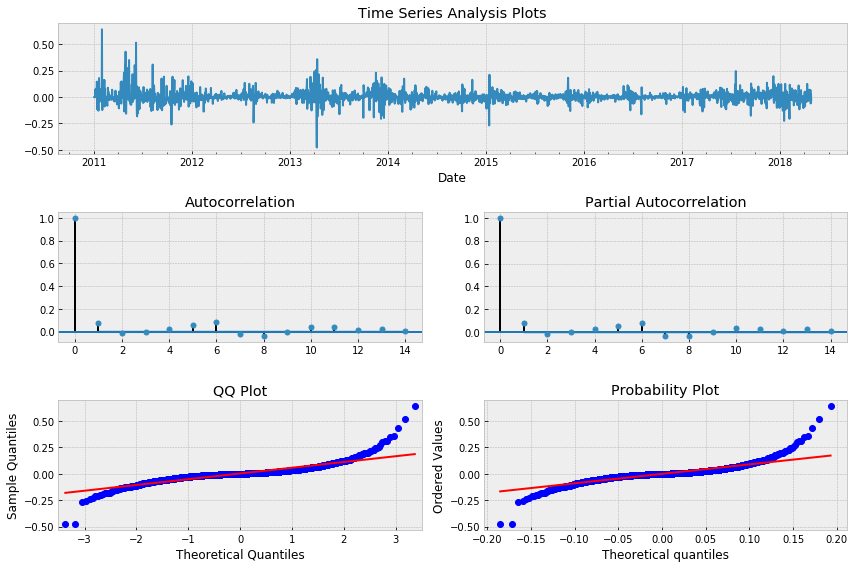

In [105]:
tsplot(data['Log Returns'].loc['2011':], lags = 14)

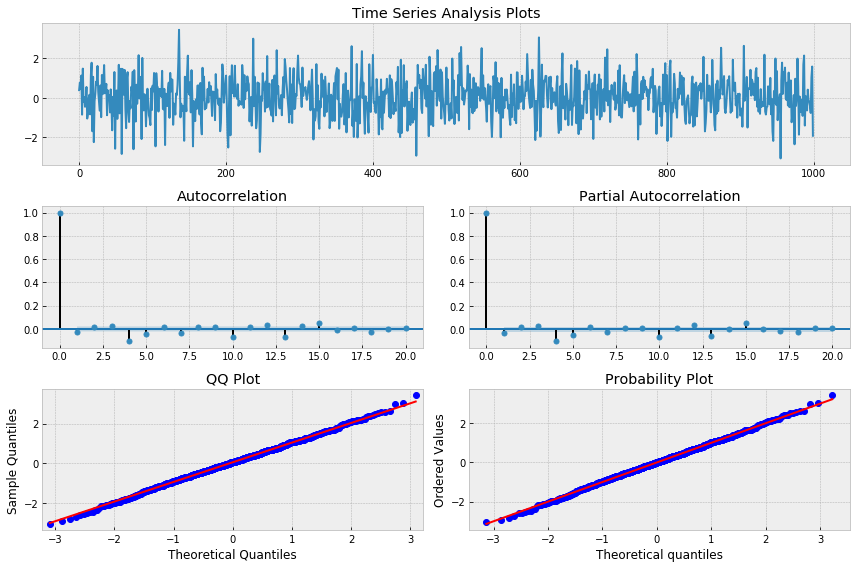

In [34]:
y = np.random.normal(size = 1000)
tsplot(y, lags = 20)

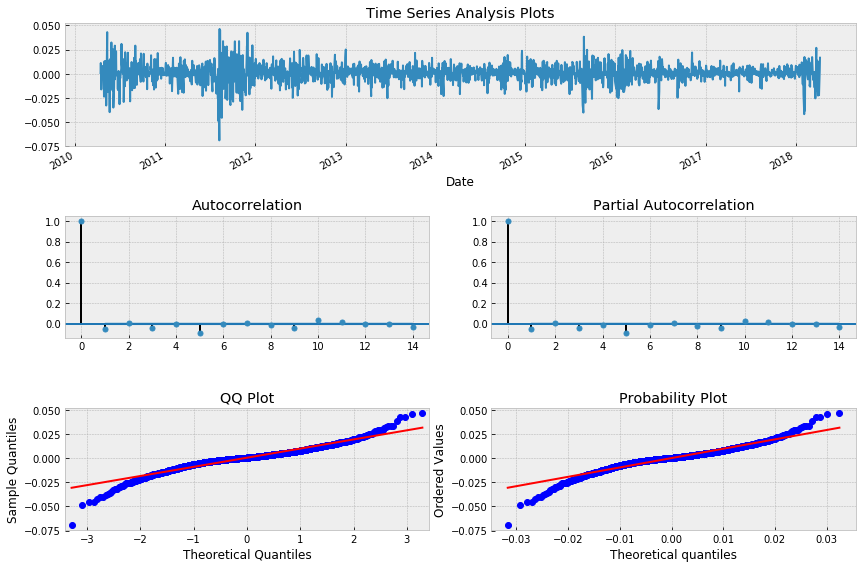

In [37]:
tsplot(sp500['Log Returns'], lags = 14)

In [60]:
data['LR Shifted'] = data['Log Returns'].shift(6)
data[['Log Returns','LR Shifted']].corr()

,Log Returns,LR Shifted
Log Returns,1.000000,0.075002
LR Shifted,0.075002,1.000000


In [72]:
# Try with weekly data
data_weekly = data.resample("W").last()

In [73]:
data_weekly['Log Returns'] = np.log(data_weekly['Value'] / data_weekly['Value'].shift(1))
data_weekly['Returns'] = data_weekly['Value'].pct_change()
data_weekly.head()

,Value,Log Returns,Returns,LR Shifted
Date,,,,
2009-01-04,0.0,NaN,NaN,NaN
2009-01-11,0.0,NaN,NaN,NaN
2009-01-18,0.0,NaN,NaN,NaN
2009-01-25,0.0,NaN,NaN,NaN
2009-02-01,0.0,NaN,NaN,NaN


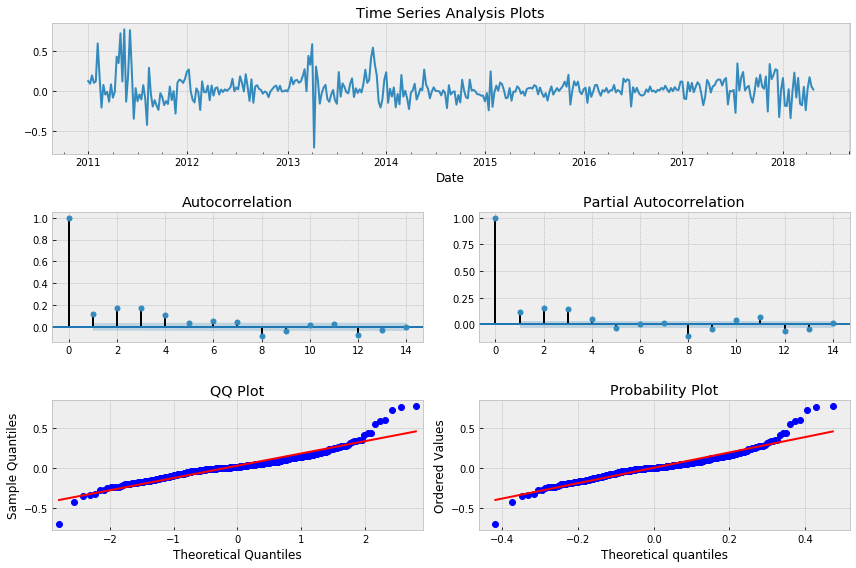

In [87]:
tsplot(data_weekly['Log Returns'].loc['2011':], lags = 14)

In [93]:
# try with inteaday data
bitcoin = pd.read_hdf('bitstampUSD','ohlc_30M')
bitcoin['Log Returns'] = np.log(bitcoin['close'] / bitcoin['close'].shift(1))

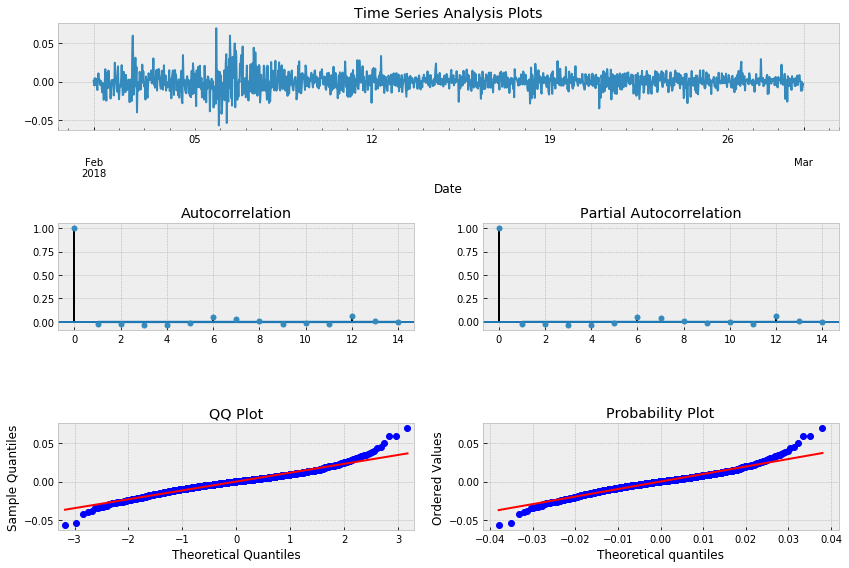

In [99]:
tsplot(bitcoin['Log Returns'].loc['2018-02'], lags = 14)

In [6]:
# try with etherium priced in BTC
etherium = quandl.get("BITFINEX/ETHBTC")

In [7]:
etherium['Log Returns'] = np.log(etherium['Last'] / etherium['Last'].shift(1))

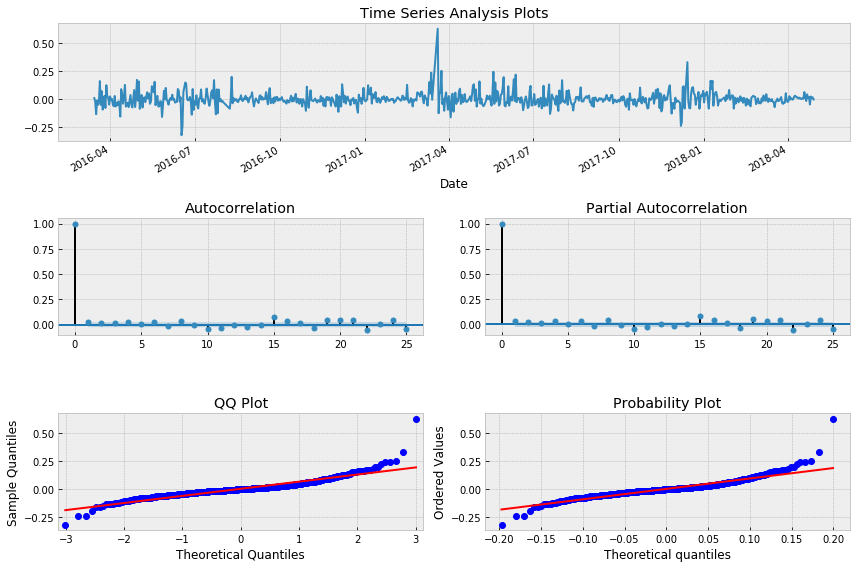

In [9]:
tsplot(etherium['Log Returns'], lags = 25) # maybe something at 15 days

In [89]:
data['Positive'] = np.where(data['Returns'] > 0,1,0)
#data['Prev Positive'] = np.where(data['Returns'].shift(1) > 0,1,0) # prev day positive
data['Prev Positive'] = np.where(data['Value'] / data['Value'].shift(6) > 1,1,0) # previous preiod positive

In [83]:
data.head(10)

,Value,Log Returns,Returns,Positive,Prev Positive
Date,,,,,
2011-01-01,0.299996,NaN,NaN,0,0
2011-01-02,0.299998,0.000007,0.000007,1,0
2011-01-03,0.299899,-0.000330,-0.000330,0,0
2011-01-04,0.298998,-0.003009,-0.003004,0,0
2011-01-05,0.299000,0.000007,0.000007,1,0
2011-01-06,0.322000,0.074108,0.076923,1,0
2011-01-07,0.322898,0.002785,0.002789,1,1
2011-01-08,0.322998,0.000310,0.000310,1,1
2011-01-09,0.329000,0.018412,0.018582,1,1


In [90]:
# % of up days
data['Positive'].sum() / float(data['Positive'].count()) * 100 # 52.079430498313975

52.04043429427181

In [92]:
# % of up days given that prev day was an up day
temp = data[data['Prev Positive'] == 1]
up_given_prev_up = temp['Positive'].sum() / float(temp['Positive'].count()) *100 # 54.06767458603312
sample_size = temp['Positive'].count() #1389
print up_given_prev_up, sample_size

61.66556510244548 1513


In [86]:
# draw random samples from full population, calculate % positive and compare to sample result of 54.06767458603312
sims = 100000
results = []
for i in np.arange(sims):
    temp = np.random.choice(data['Returns'].dropna(),sample_size,replace = False)
    results.append(np.round((temp > 0).sum() / float(sample_size) * 100,2))

In [87]:
np.mean(results) 

52.08067740000001

In [88]:
count = 0
for i in results:
    if i >= float(up_given_prev_up):
        count += 1
        
print count / float(sims) * 100 # 1.62%

# If prev day is positive:
# There is a +- 1.8% chance of randomly getting a sample with a result of 54% or more
# Significant at the 5% level but not a very strong result

# When using prev 7 days the result of 60% is statistically significant 
# When using prev 6 days the result of 63% is statistically significant

0.0


(array([3.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 2.300e+01, 3.000e+01,
        5.300e+01, 8.300e+01, 1.120e+02, 3.160e+02, 3.300e+02, 4.530e+02,
        6.560e+02, 1.511e+03, 1.415e+03, 1.822e+03, 2.262e+03, 4.465e+03,
        3.732e+03, 4.250e+03, 4.850e+03, 5.351e+03, 8.739e+03, 6.256e+03,
        6.133e+03, 6.156e+03, 5.934e+03, 8.155e+03, 4.936e+03, 4.330e+03,
        3.794e+03, 4.461e+03, 2.362e+03, 1.772e+03, 1.494e+03, 1.557e+03,
        7.060e+02, 4.960e+02, 3.520e+02, 2.410e+02, 1.910e+02, 8.300e+01,
        5.200e+01, 3.300e+01, 1.800e+01, 1.200e+01, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00]),
 array([48.43  , 48.5784, 48.7268, 48.8752, 49.0236, 49.172 , 49.3204,
        49.4688, 49.6172, 49.7656, 49.914 , 50.0624, 50.2108, 50.3592,
        50.5076, 50.656 , 50.8044, 50.9528, 51.1012, 51.2496, 51.398 ,
        51.5464, 51.6948, 51.8432, 51.9916, 52.14  , 52.2884, 52.4368,
        52.5852, 52.7336, 52.882 , 53.0304, 53.1788, 53.3272, 53.4756,
        53.624 , 53.7

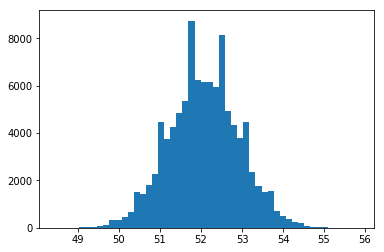

In [81]:
plt.hist(results, bins = 50)

In [25]:
# look at correlation using different lookback and holding periods
results = []
for lookback in np.arange(1,50):  #[1,6,10,25,30,60,120,250]
    for hold in np.arange(1,50):
        ret_lookback = data['Value'] / data['Value'].shift(lookback) - 1
        ret_hold = data['Value'].shift(-hold) / data['Value'] - 1
        # need to remove dates with no values from both
        # one way is to do this in a DataFrame
        df = pd.DataFrame({'ret_lookback' : ret_lookback, 'ret_hold': ret_hold})
        df.dropna(inplace = True)

        #if lookback >= hold:
        #    indep_set = np.arange(0,len(df),lookback)
        #else:
        #    indep_set = np.arange(0,len(df),hold)
        
        indep_set = np.arange(0,len(df),hold) #jump hold to hold
        
        df = df.iloc[indep_set]
        #ret_lookback = ret_lookback.iloc[indep_set]
        #ret_hold = ret_hold.iloc[indep_set]
        
        # convert to signs only
        df['ret_lookback'] = np.sign(df['ret_lookback'])
        df['ret_hold'] = np.sign(df['ret_hold'])
        
        #df.corr()
        results.append((lookback, hold, np.corrcoef(df['ret_lookback'], df['ret_hold'])[0, 1]))

sorted(results, key = lambda x: -x[2])[:20]

[(32, 46, 0.4291689314081015),
 (33, 46, 0.40779220779220765),
 (13, 38, 0.3983137534078458),
 (12, 44, 0.39633094239756916),
 (29, 46, 0.3768891807222046),
 (35, 33, 0.37641461268825765),
 (27, 46, 0.37629990816569214),
 (1, 44, 0.3743577554782662),
 (2, 44, 0.3716308976136256),
 (31, 46, 0.3656772505598269),
 (12, 47, 0.36526726041721047),
 (34, 41, 0.36154884600181714),
 (17, 49, 0.3589685542997745),
 (18, 49, 0.3589685542997745),
 (19, 49, 0.35896855429977437),
 (34, 46, 0.356753034006338),
 (21, 40, 0.35609756097560974),
 (26, 31, 0.356060606060606),
 (13, 14, 0.3544002718314647),
 (6, 30, 0.35337918344271535)]